# Sentiment Analysis with TensorFlow

## Downloading the Dataset

In [ ]:
url="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [ ]:
import tensorflow as tf

In [ ]:
dataset= tf.keras.utils.get_file("aclImdb_v1",
                        url,
                        untar=True,
                        cache_dir=".",
                        cache_subdir=" ")

In [ ]:
import os
dataset_dir=os.path.join(os.path.dirname(dataset),"aclImdb")

In [ ]:
os.listdir(dataset_dir)

['train', 'README', 'imdbEr.txt', 'imdb.vocab', 'test']

In [ ]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'neg',
 'unsup',
 'unsupBow.feat',
 'urls_unsup.txt',
 'labeledBow.feat',
 'pos']

In [ ]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir=os.path.join(train_dir,"unsup")
import shutil
shutil.rmtree(remove_dir)

## Loading the Dataset

In [ ]:
batch_size=32
seed = 42
raw_train_ds=tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
import numpy as np
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
raw_val_ds=tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
test_dir = os.path.join(dataset_dir, "test")
raw_test_ds=tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


## Data Preprocessing

In [ ]:
import re
import string
def custom_standardization(input_data):
  lowercase=tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation), '')

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = 10000
sequence_length = 250
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = "int",
    output_sequence_length=sequence_length
)

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text=tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))

In [ ]:
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [ ]:
print("128 -->",vectorize_layer.get_vocabulary()[128])
print("1312 -->",vectorize_layer.get_vocabulary()[1312])
print("Vocabulary size: {}" .format(len(vectorize_layer.get_vocabulary())))

128 --> here
1312 --> thus
Vocabulary size: 10000


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the Dataset for Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the Model

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features +1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)                     
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Compiling the Model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = "adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)           
)

## Training the Model

In [ ]:
epochs=10
histroy=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.6662 - binary_accuracy: 0.6913 - val_loss: 0.6177 - val_binary_accuracy: 0.7676
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5507 - binary_accuracy: 0.7987 - val_loss: 0.4998 - val_binary_accuracy: 0.8214
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4463 - binary_accuracy: 0.8451 - val_loss: 0.4214 - val_binary_accuracy: 0.8458
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3802 - binary_accuracy: 0.8648 - val_loss: 0.3748 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3366 - binary_accuracy: 0.8770 - val_loss: 0.3460 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3060 - binary_accuracy: 0.8888 - val_loss: 0.3268 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

## Evaluating the Model

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3109 - binary_accuracy: 0.8729
Loss:  0.3109152019023895
Accuracy:  0.8728799819946289


## Plot of Accuracy and Loss

In [ ]:
history_dict=histroy.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [ ]:
import matplotlib.pyplot as plt
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

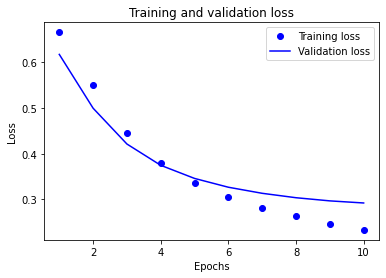

In [ ]:
epochs = range(1,len(acc)+1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

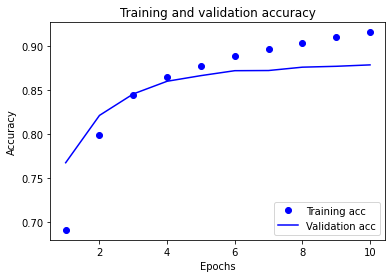

In [ ]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

## Exporting the Model

In [ ]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    tf.keras.layers.Activation("sigmoid")
])

In [ ]:
export_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     optimizer = "adam",
                     metrics=["accuracy"])

In [ ]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 10ms/step - loss: 0.3109 - accuracy: 0.8729
0.8728799819946289


## Predicting New Data

In [ ]:
examples = [
            "The movie was perfect",
            "The movie was okay",
            "The movie was awful"
]

In [ ]:
export_model.predict(examples)

array([[0.6065665],
       [0.4287504],
       [0.3101297]], dtype=float32)

Thank you for reading. Don't forget subscribe [tirendazakademi](https://youtube.com/tirendazakademi)